Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.layers.experimental import preprocessing

Access Dataset
- Within the Dataset, patient age and sex is provided with diagnosis for both the left and right eye being given. One hot encoding is used for the ocular conditions, each condition is represented by its own column where for each image a binary value of 1 or 0 is given to indicate the absence of presence of a disease. The labels coloumn includes the actual diagnosis label for the patient with the target column providing a binary vector representation of the conditions aligning with the individual conditions problem. 




In [2]:
df_data = pd.read_csv('dataset\\full_df.csv')
df_data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


Dataset Information

In [3]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

Dataset Function 

In [3]:
def parse_image_and_label(image_path, label_string):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32)
    #image = tf.keras.applications.resnet50.preprocess_input(image)
    label = tf.strings.substr(label_string, 1, tf.strings.length(label_string) - 2)  # Remove brackets
    label = tf.strings.to_number(tf.strings.split(label, ','), out_type=tf.float32)


    return image, label

def load_and_prepare_dataset(csv_path, images_dir):
    df = pd.read_csv(csv_path)
    images_left = images_dir + df['Left-Fundus']
    images_right = images_dir + df['Right-Fundus']
    labels_left = df['target'].values  
    labels_right = df['target'].values
    

    # Combine the left and right images and labels
    filenames = np.concatenate([images_left, images_right])
    labels = np.concatenate([labels_left, labels_right])


    # Creating TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(parse_image_and_label)  # Apply preprocessing function

    return dataset

Loading Training Data 

In [4]:
csv_path = 'dataset/full_df.csv'
images_dir = 'dataset/ODIR-5K/Training Images/' 

train_dataset = load_and_prepare_dataset(csv_path, images_dir)

# Now you can batch, shuffle, and prefetch the dataset as needed
train_dataset = train_dataset.batch(32)  # batching
train_dataset = train_dataset.shuffle(buffer_size=1000)  # shuffling
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)  # prefetching


C:\Users\duwak\anaconda3\Lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


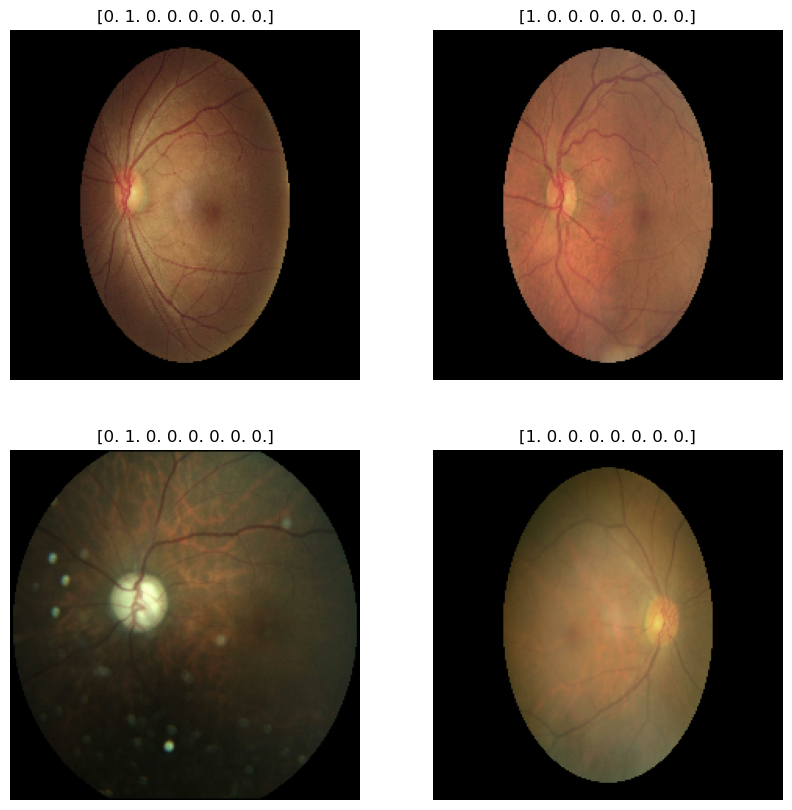

In [5]:
# Visualize the data
plt.figure(figsize=(10,10))

for i, (image, label) in enumerate(train_dataset.take(4)):
    ax = plt.subplot(2,2,i+1)
    plt.imshow(image[0] / 255)
    plt.title(label[0].numpy())
    plt.axis('off')

Loading Validation Data 

In [9]:
import os   
from concurrent.futures import ThreadPoolExecutor
images_path = 'dataset\\preprocessed_images\\'
images = []
labels = []

def load_process_image(image_path, label):
    try:
        img = tf.io.read_file(image_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [224, 224])
        img = tf.cast(img, tf.float32)
        img = img / 255.0
        label = tf.strings.substr(label, 1, tf.strings.length(label) - 2)  # Remove brackets
        label = tf.strings.to_number(tf.strings.split(label, ','), out_type=tf.float32)
        return img, label
    except Exception as e:
        return None, None

def handle_image_result(result):
    if result[0] is not None:
        images.append(result[0])
        labels.append(result[1])


with ThreadPoolExecutor(max_workers=8) as executor:
    futures = []
    for _, row in df_data.iterrows():
        left_image_path = images_path + row['Left-Fundus']
        right_image_path = images_path + row['Right-Fundus']
        futures.append(executor.submit(load_process_image, left_image_path, row['target']))
        futures.append(executor.submit(load_process_image, right_image_path, row['target']))
    
    for future in futures:
        handle_image_result(future.result())

images = np.array(images)
labels = np.array(labels)

In [12]:
val_ds = tf.data.Dataset.from_tensor_slices((images, labels))
val_ds = val_ds.batch(32)
val_ds = val_ds.prefetch(tf.data.experimental.AUTOTUNE)

#visualize the data

plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(val_ds.take(4)):
    ax = plt.subplot(2,2,i+1)
    plt.imshow(image[0] / 255)
    plt.title(label[0].numpy())
    plt.axis('off')
    

Loading Testing Data 

In [11]:
def parse_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32)
    
    return image

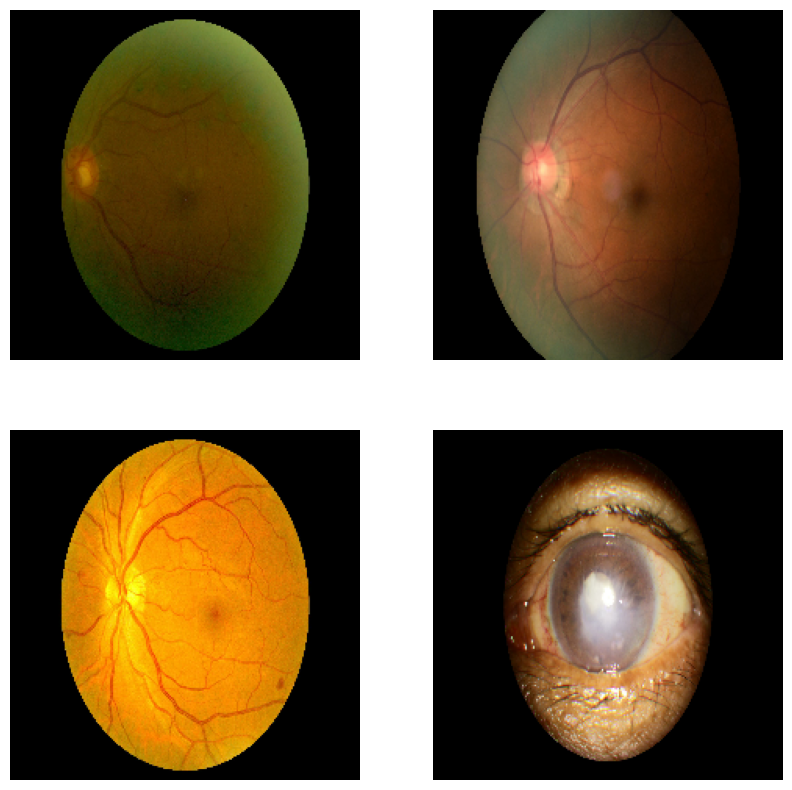

In [88]:
from pathlib import Path


data_dir = Path('dataset/ODIR-5K/')
test_dataset = list(data_dir.glob('Testing Images/*'))


test_dataset = [str(path) for path in test_dataset]
test_dataset = tf.data.Dataset.from_tensor_slices(test_dataset)
test_dataset = test_dataset.map(parse_image)


# Now you can batch, shuffle, and prefetch the dataset as needed
test_dataset = test_dataset.batch(32)  # batching
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)  # prefetching


# Visualize the data
plt.figure(figsize=(10,10))

for i, image in enumerate(test_dataset.take(4)):
    ax = plt.subplot(2,2,i+1)
    plt.imshow(image[0] / 255)
    plt.axis('off')



In [10]:
#print("Number of Images in Training Dataset: ",train_dataset.__len__()) 
print("Number of Images in Testing Dataset: ",test_dataset.__len__())
print("Number of Images in Validation Dataset: ",validation_ds.__len__())


NameError: name 'train_dataset' is not defined

Training the model

In [77]:
resnet_50_model = Sequential()

pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg', classes=8,
    weights='imagenet')

for layer in pretrained_model.layers:
    layer.trainable = False

resnet_50_model.add(pretrained_model)
resnet_50_model.add(Flatten())
resnet_50_model.add(Dense(512, activation='relu'))
resnet_50_model.add(Dense(8, activation='softmax'))

In [78]:
resnet_50_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dense_3 (Dense)             (None, 8)                 4104      
                                                                 
Total params: 24640904 (94.00 MB)
Trainable params: 1053192 (4.02 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [79]:
resnet_50_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [81]:
epochs = 10
history = resnet_50_model.fit(train_dataset,test_dataset, epochs=epochs)


Epoch 1/10
400/400 [==============================] - 758s 2s/step - loss: 1.4574 - accuracy: 0.4555 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
400/400 [==============================] - 694s 2s/step - loss: 1.3131 - accuracy: 0.5078 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/10
400/400 [==============================] - 696s 2s/step - loss: 1.2759 - accuracy: 0.5165 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 4/10
400/400 [==============================] - 695s 2s/step - loss: 1.2316 - accuracy: 0.5314 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 5/10
400/400 [==============================] - 684s 2s/step - loss: 1.1939 - accuracy: 0.5503 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 6/10
400/400 [==============================] - 718s 2s/step - loss: 1.1833 - accuracy: 0.5505 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 7/10
400/400 [==============================] - 695s 2s/step - loss: 1.1638 - accuracy: 

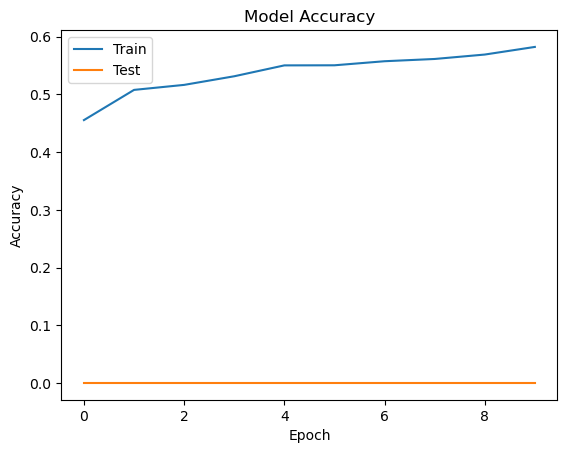

In [82]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Resnet-50 Model

In [25]:
model =  Sequential()

resnet_50 = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(256, 256, 3),
    pooling='avg', classes=8,
)

for each_layer in resnet_50.layers:
    each_layer.trainable = False

model.add(resnet_50)

In [16]:
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(8, activation='softmax'))

Training ResNet-50 model

In [18]:
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(images, labels, epochs=10, validation_split=0.2)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 8)                 8200      
                                                                 
Total params: 25694088 (98.02 MB)
Trainable params: 2106376 (8.04 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


Data Distribution
- Below is shown the distribution of images available for each different ocular condition. The different diseases are encoded into individual coloums as N (Normal), D (Diabetes), G (Glaucoma), C (Cataract) , A (Age related Macular Degeneration), H (Hypertension), M (Pathological Myopia), O (Other diseases/abnormalities). They have binary indicators 0 or 1 to specify the absence or presence of a condition. This is also know as one-hot encoding. Thus, the dataset structure indicates multiple labels per image, allowing for multi-label classifcation.

- Conditions G, C, A, H, M, O have low image samples, thus need for balancing these classes is required.

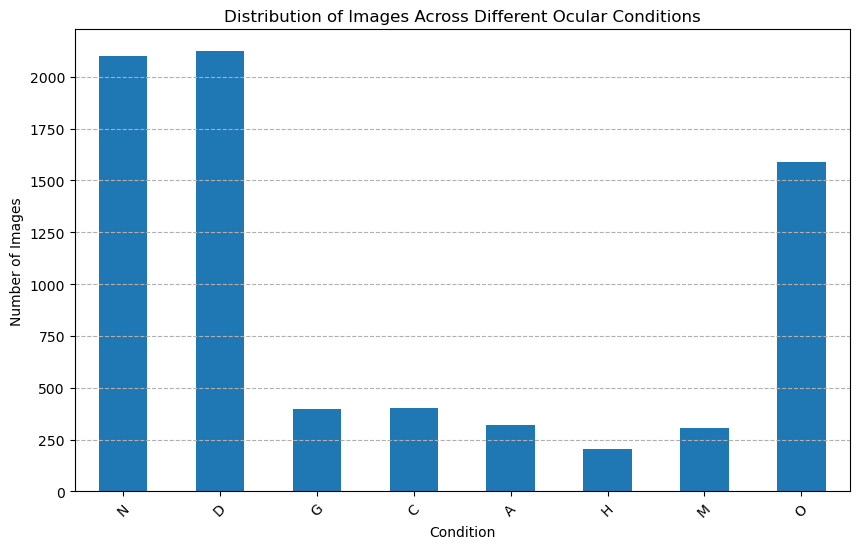

In [6]:
# Sum up the occurrences of each condition
class_counts = df_data[['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']].sum()

# Plotting
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Distribution of Images Across Different Ocular Conditions')
plt.xlabel('Condition')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')

plt.show()

In [7]:
class_distribution = df_data[['N','D','G', 'C', 'A', 'H', 'M', 'O']].sum()
print(class_distribution)

N    2101
D    2123
G     397
C     402
A     319
H     203
M     306
O    1588
dtype: int64


Dealing with class imbalance - Calculating class weights 
- This one approach to resolving the class imbalance, the class weights calculated will make the CNN model more sensitive to underrepresented classes and improve its overall performance on imbalanced datasets. Higher class weight will mean that a single sample from a higher weight class would be considered as 7 samples from a class with lower weights. 


In [8]:
# The dataset is imbalanced, so we will use class weights to balance it out during training                     
total_samples = class_counts.sum()
class_weights = {
    0: total_samples / class_counts[0],
    1: total_samples / class_counts[1],
    2: total_samples / class_counts[2],
    3: total_samples / class_counts[3],
    4: total_samples / class_counts[4],
    5: total_samples / class_counts[5],
    6: total_samples / class_counts[6],
    7: total_samples / class_counts[7]
}       

Loading and Visualising the Imbalanced Target Classes 

In [23]:
images_path = 'dataset/ODIR-5K/Training Images/'  # Adjusted for consistency
target_classes = ['G', 'C', 'A', 'H', 'M', 'O']

target_images = []
target_labels = []

def load_process_target_image(file_path, label):
    if os.path.exists(file_path):
        img = tf.keras.preprocessing.image.load_img(file_path, target_size=(256, 256))
        img = tf.keras.preprocessing.image.img_to_array(img)
        return img, label
    return None, None

def handle_target_image_result(result):
    img, label = result
    if img is not None:
        target_images.append(img)
        target_labels.append(label)

# Use ThreadPoolExecutor to load and process images that match target_classes
with ThreadPoolExecutor(max_workers=8) as executor:
    futures = []
    for _, row in df_data.iterrows():
        # For each target class, check if the condition is present for either eye
        for target_class in target_classes:
            if target_class in row and row[target_class] == 1:  # Check if the condition is marked for this row
                # Check each eye and process the image if the condition is present
                if 'Left-Fundus' in row and row[target_class] == 1:
                    left_image_path = os.path.join(images_path, row['Left-Fundus'])
                    futures.append(executor.submit(load_process_target_image, left_image_path, (row['Left-Diagnostic Keywords'])))
                if 'Right-Fundus' + target_class in row and row[target_class] == 1:
                    right_image_path = os.path.join(images_path, row['Right-Fundus'])
                    futures.append(executor.submit(load_process_target_image, right_image_path, (row['Right-Diagnostic Keywords'])))
    
    
    for future in futures:
        handle_target_image_result(future.result())

# Convert to NumPy arrays
target_images = np.array(target_images)
target_labels = np.array(target_labels)

length_of_target_images = len(target_images)
print(length_of_target_images)

print(f"Shape of training images: {target_images.shape}")
print(f"Shape of training labels: {target_labels.shape}")

3215
Shape of training images: (3215, 256, 256, 3)
Shape of training labels: (3215,)


c:\Users\duwak\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65292 (\N{FULLWIDTH COMMA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


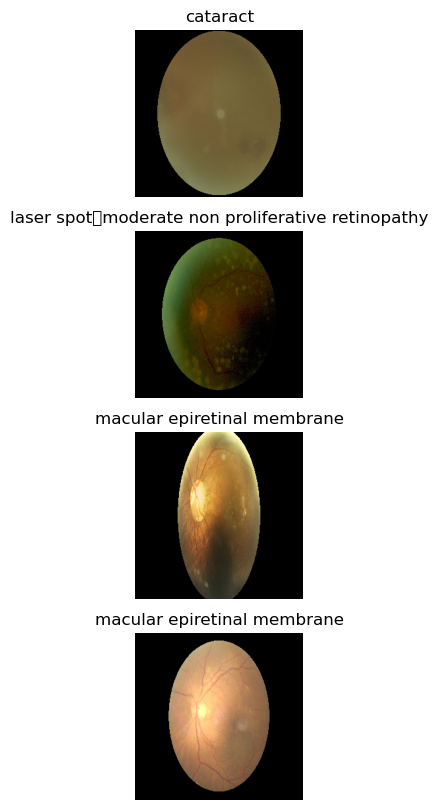

In [10]:
plt.figure(figsize=(10,10))

for i in range(4):
    plt.subplot(4,1,i+1)
    plt.imshow(target_images[i] / 255)
    plt.title(target_labels[i])
    plt.axis('off')

plt.show()


Dealing with class imbalance - Data Augmentation 
- Data augmentation involves artificially increasing the size of your dataset by generating new data by resusing exisitng data, useful for underrepresented classes. Examples include rotations, flipping, noise, colour variations. 

In [11]:
# Assuming df_data is your DataFrame and images_path is defined
# Define the augmentation parameters
augmentation = ImageDataGenerator(
    rotation_range=40,  # random angle degrees 
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],  # Added brightness range for noise
    channel_shift_range=50,  # Added channel shift range for noise
    fill_mode='nearest'  # Filling mode for augmented images
)

# Initialize lists to store augmented images and labels
augmented_images = []
augmented_labels = []

for img, label in zip(target_images, target_labels):
    # Original image
    augmented_images.append(img)
    augmented_labels.append(label)
    
    # Augmented image with noise
    img_augmented = augmentation.random_transform(img)
    augmented_images.append(img_augmented)
    augmented_labels.append(label)

# Convert the list of images to a NumPy array
augmented_images = np.array(augmented_images)



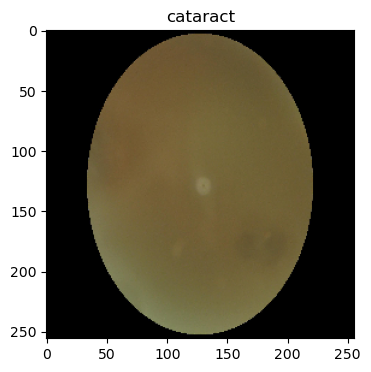

In [12]:
# Display the first augmented image and its label, if available
if len(augmented_images) > 0:
    plt.figure(figsize=(4,4))
    plt.imshow(augmented_images[0] / 255.0)  # Normalize the image
    plt.title(augmented_labels[0])
    plt.show()
else:
    print("No augmented images were created.")

Dealing with Class Imbalance - CGANs synthetic image generation
- Using Conditional Generative Adversarial Networks to generate synthetic images for underrespresented classes in the dataset. 

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, Conv2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from keras.layers import Input, Dense, Embedding, Flatten, Reshape, multiply, Conv2D, LeakyReLU, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, Conv2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from keras.layers import Input, Dense, Embedding, Flatten, Reshape, multiply, Conv2D, LeakyReLU, Dropout


from keras.layers import Input, Dense, Reshape, Conv2DTranspose, Embedding, Flatten, Multiply, Concatenate



In [14]:
def build_generator(z_dim, num_classes):
    # Noise input
    noise_input = Input(shape=(z_dim,))

    # Label input
    label_input = Input(shape=(1,), dtype='int32')
    
    # Embedding for the label, producing an output of the same shape as the noise vector
    label_embedding = Embedding(num_classes, z_dim)(label_input)
    label_embedding = Flatten()(label_embedding)
    
    # Merge the noise and the label embedding via multiplication or concatenation
    merged_input = Multiply()([noise_input, label_embedding])

    # Dense layer
    x = Dense(128 * 16 * 16)(noise_input)
    x = Reshape((16, 16, 128))(x)
    
    # Upsampling layers
    x = Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', activation='relu')(x)  # To 32x32
    x = Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', activation='relu')(x)   # To 64x64
    x = Conv2DTranspose(32, kernel_size=4, strides=2, padding='same', activation='relu')(x)   # To 128x128
    x = Conv2DTranspose(3, kernel_size=4, strides=2, padding='same', activation='sigmoid')(x) # To 256x256
    
    # Create the model
    model = Model(inputs=[noise_input, label_input], outputs=x)
    
    return model    

In [15]:
def build_discriminator(img_shape, num_classes):
    # Input layer for the image
    img_input = Input(shape=img_shape)
    
    # Assuming you want to keep using convolutions similar to your autoencoder structure
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Flatten()(x)
    
    # Input layer for the label
    label_input = Input(shape=(1,), dtype='int32')
    label_embedding = Embedding(num_classes, 50)(label_input)
    label_embedding = Flatten()(label_embedding)
    
    # Combine image and label paths
    combined = concatenate([x, label_embedding])
    
    validity = Dense(1, activation='sigmoid')(combined)
    
    model = Model(inputs=[img_input, label_input], outputs=validity)
    return model

In [16]:
def build_gan(generator, discriminator, z_dim, num_classes):
    # Ensure the discriminator's trainable attribute is set correctly
    discriminator.trainable = False
    
    # Define the GAN's noise and label inputs
    gan_noise_input = Input(shape=(z_dim,))
    gan_label_input = Input(shape=(1,), dtype='int32')
    
    # Generate an image based on noise and label inputs
    generated_image = generator([gan_noise_input, gan_label_input])
    
    # The discriminator determines the validity of the generated image and label
    gan_output = discriminator([generated_image, gan_label_input])
    
    # Initialize the GAN model with noise and label inputs, and the discriminator's validity output
    gan = Model([gan_noise_input, gan_label_input], gan_output)
    
    return gan

1/1 [==============================] - 0s 219ms/step
0 [D loss: 19.642777621746063, acc.: 34.375] [G loss: 4.482370971055424e-17]
1/1 [==============================] - 0s 269ms/step


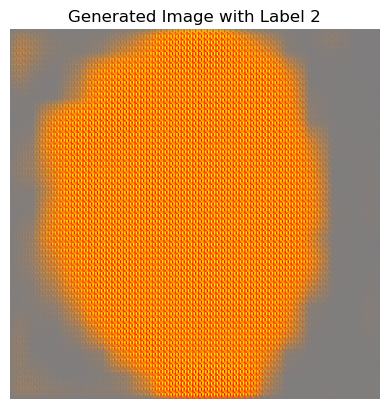

In [22]:
from sklearn.preprocessing import LabelEncoder
import re
from tensorflow.keras.layers import concatenate

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Remove non-numeric characters from target_labels
target_labels_cleaned = [re.sub(r'\D', '', label) for label in target_labels]

# Encode the cleaned target labels
encoded_labels = label_encoder.fit_transform(target_labels_cleaned)

# Define the training procedure
#@tf.function
def train_gan(gan, generator, discriminator, target_images, target_labels, z_dim, epochs=100, batch_size=64):
    half_batch = int(batch_size / 2)
    for epoch in range(epochs):
        # Train Discriminator on Real Images
        idx = np.random.randint(0, target_images.shape[0], half_batch)
        real_imgs = target_images[idx]
        real_labels = target_labels[idx]
    
        d_loss_real = discriminator.train_on_batch([real_imgs, real_labels], np.ones((half_batch, 1)))

        # Train Discriminator on Fake Images
        noise = np.random.normal(0, 1, (half_batch, z_dim))
        # Generate a half batch of new images
        fake_labels = np.random.randint(0, num_classes, half_batch)  # Generate random labels for fake images
        gen_imgs = generator.predict([noise, fake_labels])

        # Update the discriminator by training on fake images
        d_loss_fake = discriminator.train_on_batch([gen_imgs, fake_labels], np.zeros((half_batch, 1)))

        # Update the discriminator loss
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train Generator
        noise = np.random.normal(0, 1, (batch_size, z_dim))
        fake_labels = np.random.randint(0, num_classes, batch_size)
       # For generator training, fake labels are used but with real label indication (ones)
        g_loss = gan.train_on_batch([noise, fake_labels], np.ones((batch_size, 1)))

        # Progress
        if epoch % 100 == 0:
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}] [G loss: {g_loss}]")

# Build and compile the discriminator
img_shape = (256, 256, 3)
num_classes = 6

discriminator = build_discriminator(img_shape, num_classes)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

# Build the generator
z_dim = 100
generator = build_generator(z_dim, num_classes)

# Build and compile the combined model
gan = build_gan(generator, discriminator, z_dim, num_classes)
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))


# Train the GAN
train_gan(gan, generator, discriminator, target_images, encoded_labels, z_dim, epochs=100, batch_size=64)

# Generate a random noise input and label
noise = np.random.normal(0, 1, (1, z_dim))
random_label = np.random.randint(0, num_classes, 1)
# Generate a label
gen_image = generator.predict([noise, random_label])

# Plot the generated image
plt.imshow(gen_image)
plt.title(f"Generated Image with Label {random_label[0]}")
plt.axis('off')
plt.show()



Improving the efficiency of the dataset
- One-hot encoding for machine learning purposes may not be most efficient for multi-label classification hence to improve the efficiency of this dataset the individual one-hot encoded columns will be converted into a single list also known as multi-hot encoding. 